In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from skimage import exposure

In [2]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

In [3]:
scene_df1 = pd.read_hdf('scene.hdf5')
scene_df2 = pd.read_hdf('scene2.hdf5')
scene_df3 = pd.read_hdf('scene3.hdf5')
car_scene_df1 = pd.read_hdf('car_scene.hdf5')
car_scene_df2 = pd.read_hdf('car_scene2.hdf5')
car_scene_df3 = pd.read_hdf('car_scene3.hdf5')

In [4]:
car_calibration_df1 = pd.read_hdf("car_calibration_set_1.hdf5")
car_calibration_df2 = pd.read_hdf("car_calibration_set_2.hdf5")

calibration_df1 = pd.read_hdf("calibration_set_1.hdf5")
calibration_df2 = pd.read_hdf("calibration_set_2.hdf5")

In [5]:
def median_denoised_df(scene_df):

    baseline = np.median(np.array(np.stack(scene_df["image"].values)), axis =0)

    return np.stack(scene_df["image"].values)-baseline
    

In [6]:
def mean_denoised_df(scene_df):

    baseline = np.mean(np.array(np.stack(scene_df["image"].values)), axis =0)

    return np.stack(scene_df["image"].values)-baseline

In [7]:
def median_denoised_video(scene):

    baseline = np.median(scene, axis =0)

    return scene-baseline

In [8]:


def median_intersection(arr, n):
    slices = np.array_split(arr, n, axis=0)
    
    # Calculate the median over axis 0 for each slice
    medians = np.array([np.median(s, axis=0) for s in slices])
    mean = np.mean(medians, axis = 0)    
    return arr- mean



In [9]:
video = np.stack(car_scene_df1["image"].values)

arr = video

In [25]:
all_scenes = [scene_df1,scene_df2,scene_df3,car_scene_df1,car_scene_df2, car_scene_df3]

for i, scene in enumerate(all_scenes):
    denoised = extract_static_noise_torch_df(scene)
    name = f"static_denoise_{i+1}.avi"
    save_video_from_images(denoised, name)

C:\Users\WillQuantique\AppData\Local\Temp\ipykernel_18916\3459172621.py:19: RuntimeWarning: invalid value encountered in cast
  img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


In [10]:
def select_least_contrasted_images(images, x):
    
    num_images = images.shape[0]
    num_selected = int(num_images * x / 100.0)
    
    contrasts = []
    for i in range(num_images):
        contrast = exposure.is_low_contrast(images[i])
        contrasts.append((i, contrast))
    
    contrasts.sort(key=lambda item: item[1])
    selected_indices = [item[0] for item in contrasts[:num_selected]]
    
    return images[selected_indices]


In [11]:
import torch

def is_low_contrast_torch(image, fraction_threshold=0.05):
    min_val = image.float().min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    max_val = image.float().max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    contrast = (max_val - min_val) / (max_val + min_val)
    return contrast < fraction_threshold

def select_least_contrasted_blocks(images, x):
    num_images, height, width = images.shape
    block_size = 32
    num_blocks_vertical = height // block_size
    num_blocks_horizontal = width // block_size
    num_selected = int(num_images * x / 100.0)
    
    images_torch = torch.tensor(images, dtype=torch.float32)
    blocks = images_torch.unfold(1, block_size, block_size).unfold(2, block_size, block_size)
    
    min_vals = blocks.contiguous().view(num_images, num_blocks_vertical, num_blocks_horizontal, -1).min(dim=-1)[0]
    max_vals = blocks.contiguous().view(num_images, num_blocks_vertical, num_blocks_horizontal, -1).max(dim=-1)[0]
    contrasts = (max_vals - min_vals) / (max_vals + min_vals)
    
    sorted_indices = contrasts.argsort(dim=0)
    best_blocks_indices = sorted_indices[:num_selected]
    
    selected_blocks = torch.gather(blocks, 0, best_blocks_indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, block_size, block_size))
    
    selected_images = selected_blocks.permute(0, 3, 1, 4, 2).contiguous().view(num_selected, height, width)
    
    return selected_images.numpy().astype(np.uint8)









In [35]:

def calculate_entropy_batch(blocks):
    hist = torch.histc(blocks.float(), bins=256, min=0, max=255)
    hist = hist.view(blocks.shape[0], -1)
    
    prob = hist / hist.sum(dim=1, keepdim=True)
    entropy = -torch.sum(prob * torch.log2(prob + 1e-10), dim=1)
    
    return entropy

def select_least_entropy_blocks(images, x):
    num_images, height, width = images.shape
    block_size = 32
    num_blocks_vertical = height // block_size
    num_blocks_horizontal = width // block_size
    num_selected = int(num_images * x / 100.0)
    
    images_torch = torch.tensor(images, dtype=torch.float32)
    blocks = images_torch.unfold(1, block_size, block_size).unfold(2, block_size, block_size)
    
    blocks_flat = blocks.contiguous().view(num_images, num_blocks_vertical * num_blocks_horizontal, block_size * block_size)
    
    entropy_values = calculate_entropy_batch(blocks_flat.view(-1, block_size * block_size))
    entropy_values = entropy_values.view(num_images, num_blocks_vertical, num_blocks_horizontal)
    
    sorted_indices = entropy_values.argsort(dim=0)
    best_blocks_indices = sorted_indices[:num_selected]
    
    selected_blocks = torch.gather(blocks, 0, best_blocks_indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, block_size, block_size))
    
    selected_images = selected_blocks.permute(0, 3, 1, 4, 2).contiguous().view(num_selected, height, width)
    
    return selected_images.numpy().astype(np.uint8)







In [12]:
lci = select_least_contrasted_images(arr, 70)


In [38]:
lcb = select_least_contrasted_blocks(arr,10)

In [37]:
leb = select_least_entropy_blocks(arr,100)

RuntimeError: shape '[180000, -1]' is invalid for input of size 256

In [25]:
lcb.shape

(60, 480, 640)

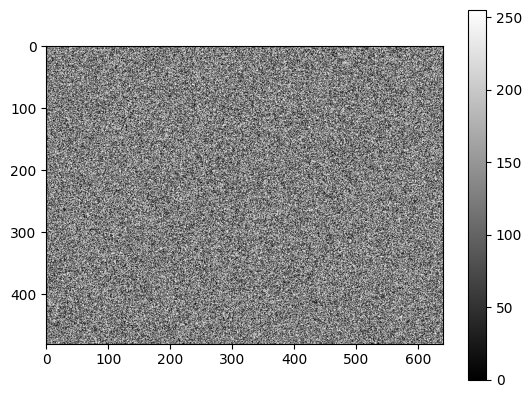

In [39]:
static = np.median(lcb, axis =0)
denoised = arr-static
plt.imshow(leb[0], cmap='gray')
plt.colorbar()

plt.show()

In [ ]:
all_scenes = [scene_df1,scene_df2,scene_df3]

for i, scene in enumerate(all_scenes):
    name = f"MSE_car_scene_{i+1}.avi"
    noise = extract_noise_pattern(np.stack(scene["image"].values))
    cleaned = remove_noise_from_video(video, noise)
    save_video_from_images(cleaned, name)

